In [ ]:
!nvidia-smi

Wed Jun 29 09:04:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-4f91e494-b31e-1fc3-0206-19f33bdeb100)


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.


In [ ]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
for i in train_lines[:20]:
  print(i, end="\n")


###24293578

OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .

METHODS	A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .

METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .

METHODS	Pain was assessed using the visual analog pain scale ( @-@ mm ) .

METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .

METHODS	Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( 

In [ ]:
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    else:
      abstract_lines+=line
  return abstract_samples


In [ ]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") 
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
train_samples[:12]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

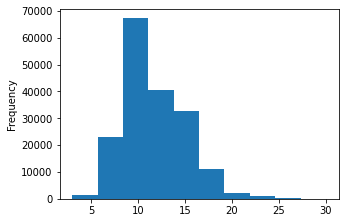

In [ ]:
train_df.total_lines.plot.hist(figsize=(5,3.5))

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))

In [ ]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))


In [ ]:
val_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
test_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
train_labels_encoded


array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
len(train_labels_encoded)

180040

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Baseline - Tfidf + Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(X=val_sentences, y = val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):

  model_accuracy = accuracy_score(y_true, y_pred) * 100

  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

###Building Sequence Models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

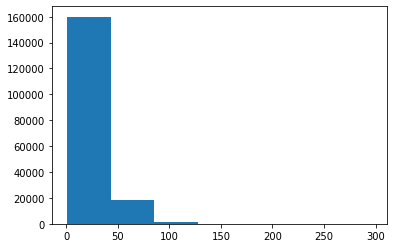

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);


In [ ]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
 max(sent_lens)

296

In [ ]:
max_tokens = 68000 #Given in the paper.

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = 55)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
the clinical utility of genotype-guided ( pharmacogenetically based ) dosing of warfarin has been tested only in small clinical trials or observational studies , with equivocal results .

Length of text: 28

Vectorized text:
[[    2    47  2049     4 10743 49129   261   915     4  2163   139   167
    567   192     5   521    47   233    16  1636   202     7 16036   117
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

In [ ]:
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name = 'token_embedding')

In [ ]:
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
the clinical utility of genotype-guided ( pharmacogenetically based ) dosing of warfarin has been tested only in small clinical trials or observational studies , with equivocal results .

Sentence after vectorization (before embedding):
[[    2    47  2049     4 10743 49129   261   915     4  2163   139   167
    567   192     5   521    47   233    16  1636   202     7 16036   117
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.00688001 -0.02390089  0.01608186 ...  0.02081187 -0.03330153
    0.04096079]
  [-0.000638   -0.01897868 -0.04263452 ...  0.04853748 -0.02753742
   -0.03579951]
  [ 0.04595437  0.02021721 -0.02634802 ... -0.0152688  -0.04516705
    0.00199192]
  ...
  [ 0.0366185   0.02505573 -0.01422445 ...  0.02800094  0.02159094
   -0.02358586]
  [ 0.0366185   0.0250557

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### 1D Convolutional Model

In [ ]:
inputs = layers.Input(shape=(1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding='same', activation = 'relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 6ms/step - loss: 0.9121 - accuracy: 0.6388 - val_loss: 0.6782 - val_accuracy: 0.7417
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.6510 - accuracy: 0.7571 - val_loss: 0.6250 - val_accuracy: 0.7763
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.6123 - accuracy: 0.7766 - val_loss: 0.5944 - val_accuracy: 0.7872


In [ ]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              epochs = 10,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/10
562/562 [==============================] - 3s 6ms/step - loss: 0.5124 - accuracy: 0.8221 - val_loss: 0.5866 - val_accuracy: 0.7892
Epoch 2/10
562/562 [==============================] - 3s 6ms/step - loss: 0.4487 - accuracy: 0.8416 - val_loss: 0.5963 - val_accuracy: 0.7852
Epoch 3/10
562/562 [==============================] - 3s 6ms/step - loss: 0.4366 - accuracy: 0.8463 - val_loss: 0.6068 - val_accuracy: 0.7789
Epoch 4/10
562/562 [==============================] - 3s 6ms/step - loss: 0.5861 - accuracy: 0.7900 - val_loss: 0.5726 - val_accuracy: 0.7916
Epoch 5/10
562/562 [==============================] - 3s 6ms/step - loss: 0.5834 - accuracy: 0.7930 - val_loss: 0.5527 - val_accuracy: 0.8005
Epoch 6/10
562/562 [==============================] - 3s 6ms/step - loss: 0.5708 - accuracy: 0.7938 - val_loss: 0.5478 - val_accuracy: 0.8009
Epoch 7/10
562/562 [==============================] - 3s 6ms/step - loss: 0.5494 - accuracy: 0.8027 - val_loss: 0.5367 - val_accuracy: 0.8098
Epoch 

In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5183 - accuracy: 0.8142


[0.5182808637619019, 0.8142459988594055]

In [ ]:
model_1_pred_probs = model_1.predict(val_sentences)


In [ ]:
model_1_pred_probs

array([[5.8314604e-01, 9.8013006e-02, 1.1343796e-01, 1.5973660e-01,
        4.5666382e-02],
       [4.8367018e-01, 2.6245981e-01, 1.4903126e-02, 2.0440808e-01,
        3.4558848e-02],
       [1.7438562e-01, 5.0688926e-03, 1.5458276e-03, 8.1891930e-01,
        8.0333106e-05],
       ...,
       [4.2336123e-06, 1.2230979e-04, 2.5369814e-03, 4.5328329e-06,
        9.9733198e-01],
       [7.8159176e-02, 5.2544206e-01, 1.3685213e-01, 4.5528833e-02,
        2.1401779e-01],
       [1.8394575e-02, 9.6430278e-01, 1.3088840e-02, 9.3090831e-04,
        3.2828168e-03]], dtype=float32)

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(y_true = val_labels_encoded, y_pred = model_1_preds)
model_1_results

{'accuracy': 81.42459949688865,
 'f1': 0.8109578148437292,
 'precision': 0.8103560542117628,
 'recall': 0.8142459949688865}

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "universal_sentence_encoder")


In [ ]:
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])

Random training sentence:
metatarsus adductus is a common pediatric foot deformity related to intrauterine molding .



In [ ]:
use_embedded_sentence.shape

TensorShape([1, 512])

In [ ]:
print(f"Sentence after embedding:\n{use_embedded_sentence}")

Sentence after embedding:
[[ 0.01957086  0.08954732 -0.01761952  0.04193586 -0.05153193 -0.04189713
   0.0116812   0.01661068  0.02446553  0.0102042   0.06820686  0.08281638
  -0.03082899  0.0632665   0.08031683 -0.05631074 -0.09380297 -0.04544327
  -0.07376179 -0.04736659 -0.08101864  0.00674424  0.059961   -0.03385213
   0.05389145 -0.01615187  0.01146602  0.01931871 -0.0062017   0.06874909
  -0.03956238  0.08879916 -0.02741722  0.07104471 -0.0278207  -0.05533249
  -0.06330281  0.09008925 -0.06594521 -0.01992238  0.01554852 -0.02986084
   0.05221952  0.0546467   0.00924512 -0.03150042 -0.02100791 -0.00481115
   0.01355759  0.03569749  0.03637778 -0.02997683  0.02317179 -0.06750373
   0.07688599 -0.08273236  0.05529003 -0.05196289  0.07793091  0.01980902
  -0.03748023 -0.04052385 -0.02550196  0.04486858 -0.06900846 -0.07005762
   0.0534706  -0.02571663  0.002371    0.00863319 -0.0264296   0.0277202
   0.04342524 -0.053192   -0.06285149 -0.0048966  -0.04324923  0.03811843
   0.04876234

### Building model with NLP feature extraction model

In [ ]:
inputs = layers.Input(shape = [], dtype = tf.string)

pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation = "relu")(pretrained_embedding)
outputs = layers.Dense(5, activation = "softmax")(x)

model_2 = tf.keras.Model(inputs,outputs)

model_2.compile(loss = "categorical_crossentropy",
                metrics = ['accuracy'],
                optimizer = tf.keras.optimizers.Adam())

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2_history = model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=10,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/10
562/562 [==============================] - 9s 12ms/step - loss: 0.9178 - accuracy: 0.6530 - val_loss: 0.7954 - val_accuracy: 0.6878
Epoch 2/10
562/562 [==============================] - 7s 12ms/step - loss: 0.7674 - accuracy: 0.7025 - val_loss: 0.7535 - val_accuracy: 0.7061
Epoch 3/10
562/562 [==============================] - 7s 12ms/step - loss: 0.7522 - accuracy: 0.7136 - val_loss: 0.7389 - val_accuracy: 0.7118
Epoch 4/10
562/562 [==============================] - 7s 12ms/step - loss: 0.7195 - accuracy: 0.7238 - val_loss: 0.7118 - val_accuracy: 0.7291
Epoch 5/10
562/562 [==============================] - 6s 11ms/step - loss: 0.7263 - accuracy: 0.7208 - val_loss: 0.6898 - val_accuracy: 0.7327
Epoch 6/10
562/562 [==============================] - 6s 12ms/step - loss: 0.7173 - accuracy: 0.7259 - val_loss: 0.6827 - val_accuracy: 0.7370
Epoch 7/10
562/562 [==============================] - 6s 11ms/step - loss: 0.6842 - accuracy: 0.7395 - val_loss: 0.6648 - val_accuracy: 0.7443

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.6532 - accuracy: 0.7506


[0.6531714797019958, 0.7506288886070251]

In [ ]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs

array([[3.4775996e-01, 5.1955056e-01, 5.6433043e-04, 1.2475245e-01,
        7.3727127e-03],
       [3.7425631e-01, 5.3511703e-01, 2.2494262e-03, 8.7468788e-02,
        9.0837333e-04],
       [4.9590975e-01, 4.0497880e-02, 2.5854072e-02, 3.9584160e-01,
        4.1896634e-02],
       ...,
       [9.2517294e-04, 4.8851455e-04, 1.9870849e-02, 1.6115056e-04,
        9.7855431e-01],
       [4.3608118e-03, 6.4181827e-02, 2.4041805e-01, 1.6229691e-03,
        6.8941635e-01],
       [5.1823661e-02, 7.8632277e-01, 1.5275487e-01, 1.0317252e-03,
        8.0670435e-03]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 0, ..., 4, 4, 1])>

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.0628889183106,
 'f1': 0.7458525193581951,
 'precision': 0.7461287123421187,
 'recall': 0.750628889183106}

### Conv1D model with character embeddings

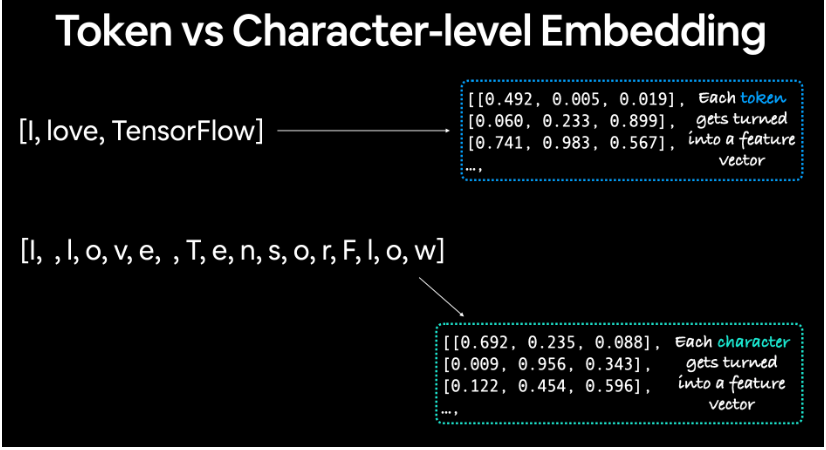

In [ ]:
def split_chars(text):
  return " ".join(list(text))

split_chars(random_training_sentence)

'm e t a t a r s u s   a d d u c t u s   i s   a   c o m m o n   p e d i a t r i c   f o o t   d e f o r m i t y   r e l a t e d   t o   i n t r a u t e r i n e   m o l d i n g   .'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

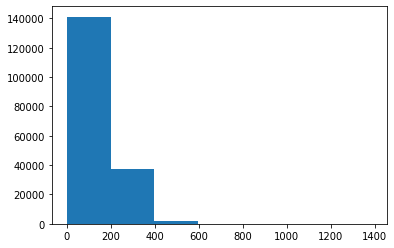

In [ ]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)


In [ ]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    standardize = "lower_and_strip_punctuation",
                                    name = 'char_vectorizer')
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:

random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
b a   c a n   a f f e c t   o u t c o m e   a f t e r   b i f u r c a t i o n   p c i   ;   @ d   a n g i o g r a p h i c   a n a l y s i s   p r o v i d e s   r e l i a b l e   b a   m e a s u r e m e n t s   .

Length of chars: 91

Vectorized chars:
[[22  5 11  5  6  5 17 17  2 11  3  7 16  3 11  7 15  2  5 17  3  2  8 22
   4 17 16  8 11  5  3  4  7  6 14 11  4 10  5  6 18  4  7 18  8  5 14 13
   4 11  5  6  5 12 19  9  4  9 14  8  7 21  4 10  2  9  8  2 12  4  5 22
  12  2 22  5 15  2  5  9 16  8  2 15  2  6  3  9  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [ ]:
char_embed = layers.Embedding(input_dim = NUM_CHAR_TOKENS,
                              output_dim = 25,
                              mask_zero = False,
                              name = 'char_embed')
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
b a   c a n   a f f e c t   o u t c o m e   a f t e r   b i f u r c a t i o n   p c i   ;   @ d   a n g i o g r a p h i c   a n a l y s i s   p r o v i d e s   r e l i a b l e   b a   m e a s u r e m e n t s   .

Embedded chars (after vectorization and embedding):
[[[ 0.01112474  0.03134895 -0.01081488 ... -0.03502323 -0.04227835
    0.01871593]
  [ 0.03765715 -0.04736936  0.03247071 ... -0.04509039 -0.02425269
    0.03038658]
  [ 0.00924825 -0.02854488 -0.04508573 ... -0.03506434 -0.02848865
   -0.0113415 ]
  ...
  [ 0.01904103 -0.01485657 -0.04216234 ... -0.02119598 -0.02951763
   -0.01226204]
  [ 0.01904103 -0.01485657 -0.04216234 ... -0.02119598 -0.02951763
   -0.01226204]
  [ 0.01904103 -0.01485657 -0.04216234 ... -0.02119598 -0.02951763
   -0.01226204]]]

Character embedding shape: (1, 290, 25)


In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=10,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/10
562/562 [==============================] - 4s 5ms/step - loss: 1.2506 - accuracy: 0.4917 - val_loss: 1.0543 - val_accuracy: 0.5791
Epoch 2/10
562/562 [==============================] - 3s 5ms/step - loss: 1.0228 - accuracy: 0.5895 - val_loss: 0.9661 - val_accuracy: 0.6213
Epoch 3/10
562/562 [==============================] - 3s 5ms/step - loss: 0.9457 - accuracy: 0.6269 - val_loss: 0.8919 - val_accuracy: 0.6569
Epoch 4/10
562/562 [==============================] - 3s 5ms/step - loss: 0.8861 - accuracy: 0.6580 - val_loss: 0.8542 - val_accuracy: 0.6782
Epoch 5/10
562/562 [==============================] - 3s 5ms/step - loss: 0.8642 - accuracy: 0.6642 - val_loss: 0.8263 - val_accuracy: 0.6875
Epoch 6/10
562/562 [==============================] - 3s 5ms/step - loss: 0.8404 - accuracy: 0.6797 - val_loss: 0.7921 - val_accuracy: 0.6945
Epoch 7/10
562/562 [==============================] - 4s 6ms/step - loss: 0.8262 - accuracy: 0.6822 - val_loss: 0.7798 - val_accuracy: 0.7011
Epoch 

In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.7577 - accuracy: 0.7155


[0.7576954960823059, 0.715510368347168]

In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.2949905 , 0.4525005 , 0.01121626, 0.23792951, 0.00336324],
       [0.12819879, 0.77970374, 0.00267248, 0.08471695, 0.00470801],
       [0.21219814, 0.13365509, 0.05930118, 0.57733274, 0.01751287],
       ...,
       [0.00462163, 0.02148993, 0.03559697, 0.00306571, 0.9352257 ],
       [0.02007607, 0.151781  , 0.05093847, 0.00785238, 0.7693521 ],
       [0.11349985, 0.8371836 , 0.02861507, 0.00733084, 0.01337076]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 71.55103932212366,
 'f1': 0.7087937584294924,
 'precision': 0.7070884770687382,
 'recall': 0.7155103932212366}

### Pretrained char embeds plus token embeds

In [ ]:
token_inputs = layers.Input(shape = [], dtype = tf.string, name = 'token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_output)

char_inputs = layers.Input(shape=(1,), dtype = tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs = char_bi_lstm)

token_char_concat = layers.Concatenate(name = 'token_char_hybrid')([token_model.output, char_model.output])

combined_dropout = layers.Dropout(0.2)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.2)(combined_dense)
output_layer = layers.Dense(num_classes, activation = "softmax")(final_dropout)


model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                       outputs = output_layer,
                       name = 'model_4_token_and_char_embeddings')




In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

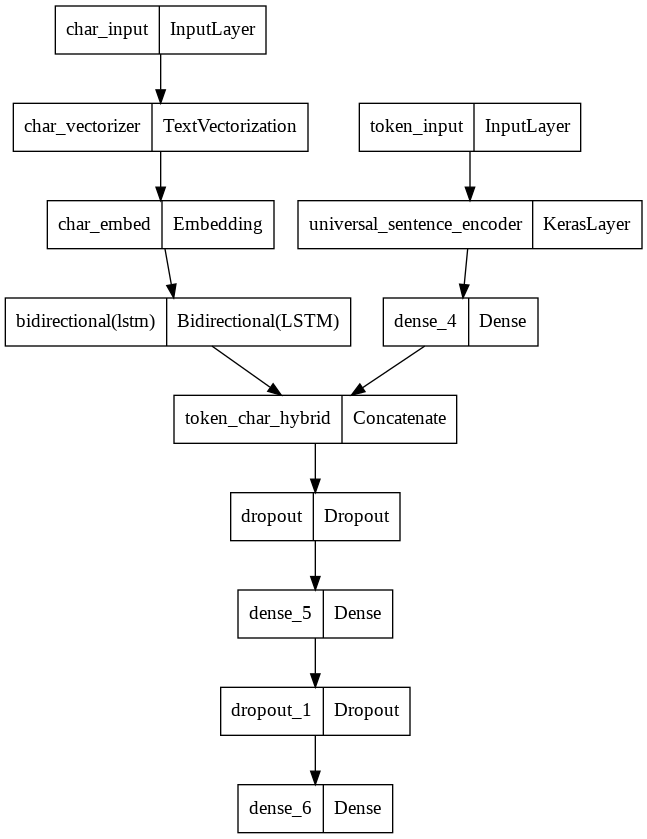

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

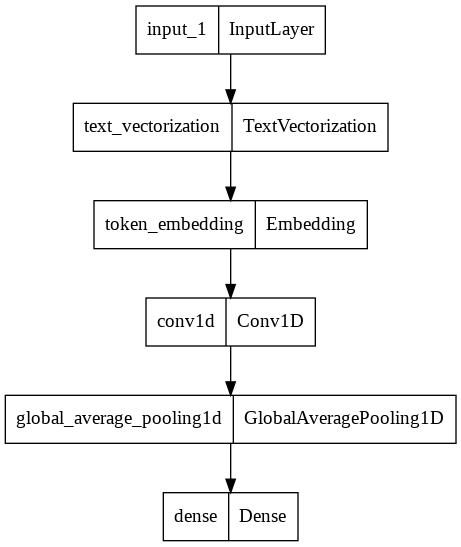

In [ ]:
plot_model(model_1)

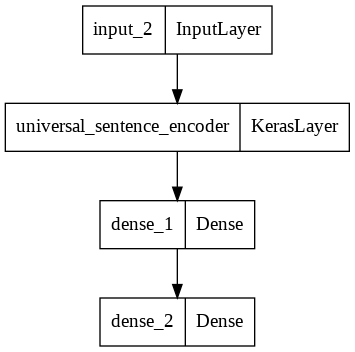

In [ ]:
plot_model(model_2)

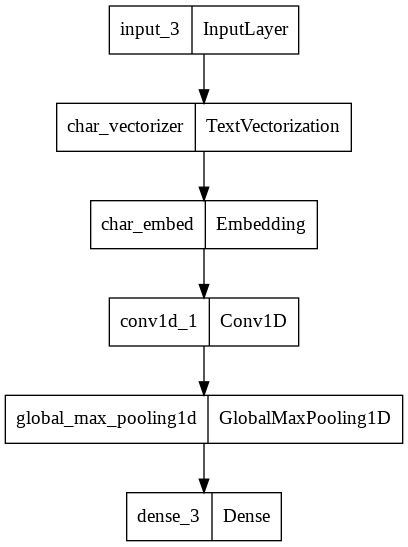

In [ ]:
plot_model(model_3)

In [ ]:
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=10,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/10
562/562 [==============================] - 23s 40ms/step - loss: 0.6787 - accuracy: 0.7430 - val_loss: 0.6442 - val_accuracy: 0.7580
Epoch 2/10
562/562 [==============================] - 19s 33ms/step - loss: 0.6475 - accuracy: 0.7504 - val_loss: 0.6223 - val_accuracy: 0.7673
Epoch 3/10
562/562 [==============================] - 19s 34ms/step - loss: 0.6449 - accuracy: 0.7501 - val_loss: 0.6125 - val_accuracy: 0.7696
Epoch 4/10
562/562 [==============================] - 19s 33ms/step - loss: 0.6464 - accuracy: 0.7557 - val_loss: 0.6072 - val_accuracy: 0.7706
Epoch 5/10
562/562 [==============================] - 19s 35ms/step - loss: 0.6585 - accuracy: 0.7507 - val_loss: 0.6054 - val_accuracy: 0.7713
Epoch 6/10
562/562 [==============================] - 19s 34ms/step - loss: 0.6582 - accuracy: 0.7474 - val_loss: 0.5956 - val_accuracy: 0.7826
Epoch 7/10
562/562 [==============================] - 19s 35ms/step - loss: 0.6319 - accuracy: 0.7592 - val_loss: 0.5985 - val_accuracy:

In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 22ms/step - loss: 0.5855 - accuracy: 0.7771


[0.5855470895767212, 0.7770753502845764]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[5.12424350e-01, 2.95821905e-01, 1.40130299e-03, 1.86791122e-01,
        3.56134214e-03],
       [3.95313352e-01, 5.12508512e-01, 2.80806585e-03, 8.82644877e-02,
        1.10550236e-03],
       [5.73641419e-01, 2.77354615e-03, 1.21124042e-02, 4.10227001e-01,
        1.24561659e-03],
       ...,
       [6.08190167e-05, 1.03454855e-04, 2.03501992e-03, 1.43581965e-05,
        9.97786283e-01],
       [1.75771397e-02, 1.19096681e-01, 5.30819334e-02, 4.58072731e-03,
        8.05663526e-01],
       [9.05806758e-03, 9.84305978e-01, 4.69435425e-03, 1.72536864e-04,
        1.76910730e-03]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 77.707533430425,
 'f1': 0.7735720227344046,
 'precision': 0.7745035948165857,
 'recall': 0.77707533430425}

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Trasfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)


In [ ]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

In [ ]:
train_df["total_lines"].value_counts()


11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

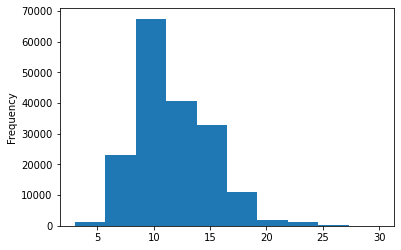

In [ ]:
train_df.total_lines.plot.hist();

In [ ]:
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

In [ ]:
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

In [ ]:
token_inputs = layers.Input(shape = [], dtype = "string", name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_outputs)

char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

line_number_inputs = layers.Input(shape = (15,), dtype = tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

total_lines_inputs = layers.Input(shape=(20,), dtype = tf.int32, name = "total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(total_lines_inputs, y)

combined_embeddings = layers.Concatenate(name = "token_char_hybrid_embedding")([token_model.output, char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.2)(z)
z = layers.Concatenate(name = "token_char_positional_embedding")([line_number_model.output, total_line_model.output,z])

output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

model_5 = tf.keras.Model(inputs = [line_number_model.input, total_line_model.input, token_model.input,
                                   char_model.input], outputs = output_layer)



In [ ]:
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

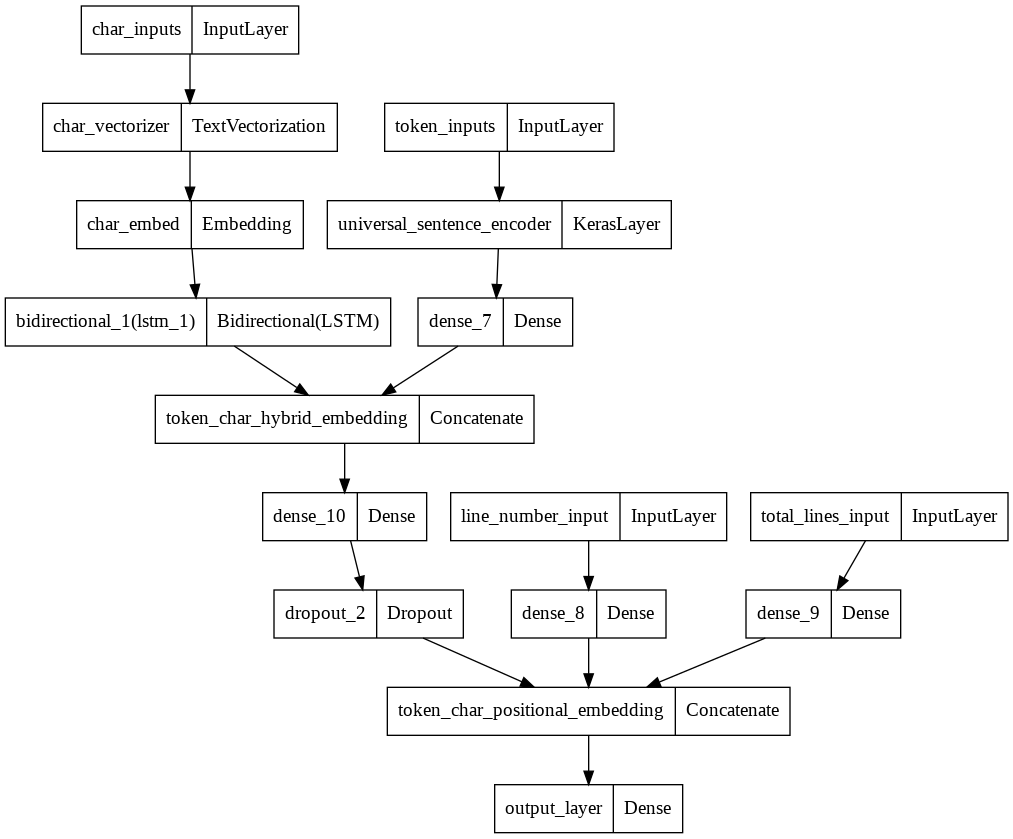

In [ ]:
plot_model(model_5)

In [ ]:
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2debb625d0> True
<keras.engine.input_layer.InputLayer object at 0x7f2deb9e4390> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f2e0cfb2450> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f2edaa4c350> False
<keras.layers.embeddings.Embedding object at 0x7f2e0cf73850> True
<keras.layers.core.dense.Dense object at 0x7f2debbce450> True
<keras.layers.wrappers.Bidirectional object at 0x7f2debcfc210> True
<keras.layers.merge.Concatenate object at 0x7f2e0ac69e90> True
<keras.engine.input_layer.InputLayer object at 0x7f2deb8be7d0> True
<keras.engine.input_layer.InputLayer object at 0x7f2debc08150> True
<keras.layers.core.dense.Dense object at 0x7f2deba466d0> True
<keras.layers.core.dense.Dense object at 0x7f2debb07910> True
<keras.layers.core.dense.Dense object at 0x7f2e0aa1f490> True
<keras.layers.core.dropout.Dropout object at 0x7f2deba46550> True
<keras.layers.merge.Concatenate object at 0x7f2deb

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, 
                                                                train_total_lines_one_hot, 
                                                                train_sentences, 
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=10,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/10
562/562 [==============================] - 23s 35ms/step - loss: 1.0061 - accuracy: 0.7826 - val_loss: 0.9691 - val_accuracy: 0.8142
Epoch 2/10
562/562 [==============================] - 18s 33ms/step - loss: 0.9550 - accuracy: 0.8226 - val_loss: 0.9450 - val_accuracy: 0.8308
Epoch 3/10
562/562 [==============================] - 18s 33ms/step - loss: 0.9404 - accuracy: 0.8276 - val_loss: 0.9333 - val_accuracy: 0.8321
Epoch 4/10
562/562 [==============================] - 18s 33ms/step - loss: 0.9310 - accuracy: 0.8385 - val_loss: 0.9248 - val_accuracy: 0.8391
Epoch 5/10
562/562 [==============================] - 18s 33ms/step - loss: 0.9294 - accuracy: 0.8372 - val_loss: 0.9202 - val_accuracy: 0.8414
Epoch 6/10
562/562 [==============================] - 19s 33ms/step - loss: 0.9320 - accuracy: 0.8366 - val_loss: 0.9162 - val_accuracy: 0.8457
Epoch 7/10
562/562 [==============================] - 19s 33ms/step - loss: 0.9204 - accuracy: 0.8419 - val_loss: 0.9208 - val_accuracy:

In [ ]:
history_full_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int( len(train_pos_char_token_dataset)),
                              epochs=10,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int( len(val_pos_char_token_dataset)))

Epoch 1/10
5627/5627 [==============================] - 186s 33ms/step - loss: 0.9010 - accuracy: 0.8571 - val_loss: 0.8970 - val_accuracy: 0.8547
Epoch 2/10
5627/5627 [==============================] - 187s 33ms/step - loss: 0.8879 - accuracy: 0.8664 - val_loss: 0.8941 - val_accuracy: 0.8572
Epoch 3/10
5627/5627 [==============================] - 186s 33ms/step - loss: 0.8782 - accuracy: 0.8738 - val_loss: 0.8956 - val_accuracy: 0.8557
Epoch 4/10
5627/5627 [==============================] - 187s 33ms/step - loss: 0.8706 - accuracy: 0.8793 - val_loss: 0.8952 - val_accuracy: 0.8565
Epoch 5/10
5627/5627 [==============================] - 188s 33ms/step - loss: 0.8640 - accuracy: 0.8848 - val_loss: 0.8964 - val_accuracy: 0.8554
Epoch 6/10
5627/5627 [==============================] - 189s 34ms/step - loss: 0.8581 - accuracy: 0.8885 - val_loss: 0.8973 - val_accuracy: 0.8543
Epoch 7/10
5627/5627 [==============================] - 190s 34ms/step - loss: 0.8531 - accuracy: 0.8929 - val_loss: 0

In [ ]:
model_5.save("pos_char_token_model")

INFO:tensorflow:Assets written to: pos_char_token_model/assets


INFO:tensorflow:Assets written to: pos_char_token_model/assets


In [ ]:
model_5.save("pos_char_token_model.pkl")

INFO:tensorflow:Assets written to: pos_char_token_model.pkl/assets


INFO:tensorflow:Assets written to: pos_char_token_model.pkl/assets


In [ ]:
!cp pos_char_token_model -r /content/drive/MyDrive/Sravanth/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "pos_char_token_model"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)#

In [ ]:
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 35s 35ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 85.37667152124983,
 'f1': 0.8512136321062118,
 'precision': 0.8546920735990701,
 'recall': 0.8537667152124984}

In [ ]:
loaded_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 21s 22ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 1, 1, 0])>

In [ ]:
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 84.9145511863282,
 'f1': 0.8465995590060523,
 'precision': 0.8492134832630014,
 'recall': 0.8491455118632819}

# Transfer Learning with bert will be on new notebook.
